# 🧠 Drebin Android Malware Classification  
**Using Feature Selection, PCA, LazyPredict & Cross-Validation**

This Colab-ready notebook presents a clean, research-quality pipeline for classifying Android malware using the Drebin dataset.  
It includes:
- Feature selection with Random Forest
- Dimensionality reduction using PCA
- Model benchmarking using LazyPredict
- Cross-validation on the best classifier
- Class imbalance visualization
- Sparse feature pruning

---


In [1]:
!pip install lazypredict scikit-learn xgboost pandas numpy seaborn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators
from google.colab import drive


## 📂 Load Drebin Dataset from Google Drive

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/drebin.csv'
data = pd.read_csv(dataset_path)
print(f"Dataset shape: {data.shape}")
data.head()


Mounted at /content/drive
Dataset shape: (7255, 216)


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,S
1,0,0,0,0,0,0,1,0,0,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,S
2,0,0,0,0,0,0,1,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,S
3,0,0,0,0,0,0,0,0,0,1,...,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,S
4,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,S


## 🧼 Data Preprocessing and Class Distribution

Object columns: ['TelephonyManager.getSimCountryIso', 'class']


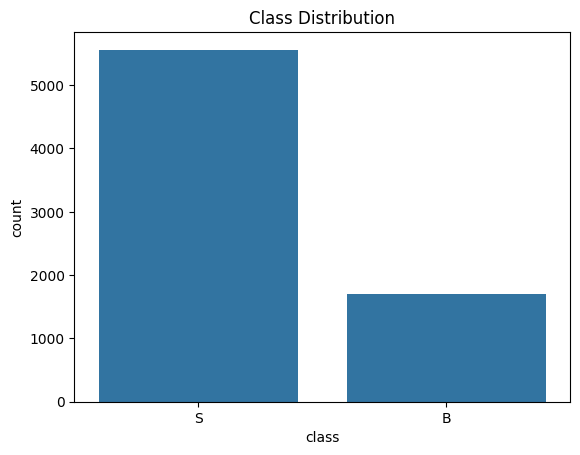

In [ ]:
# Drop or encode object columns
object_cols = data.select_dtypes(include='object').columns.tolist()
print("Object columns:", object_cols)

# Drop non-informative ID-like columns
data.drop(columns=[col for col in object_cols if col != 'class'], inplace=True)

# Separate features and target
X = data.drop(columns=['class'])
y = data['class']

# Visualize class distribution
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

# Encode target
y = LabelEncoder().fit_transform(y)

# Fill NA and force numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)


In [ ]:
# Drop classes with only 1 sample (to prevent classifier issues)
class_counts = pd.Series(y).value_counts()
minority_classes = class_counts[class_counts < 2].index.tolist()
for cls in minority_classes:
    indices_to_drop = np.where(y == cls)[0]
    X = X.drop(index=indices_to_drop)
    y = np.delete(y, indices_to_drop)


## 🔍 Train/Test Split, Feature Selection, PCA

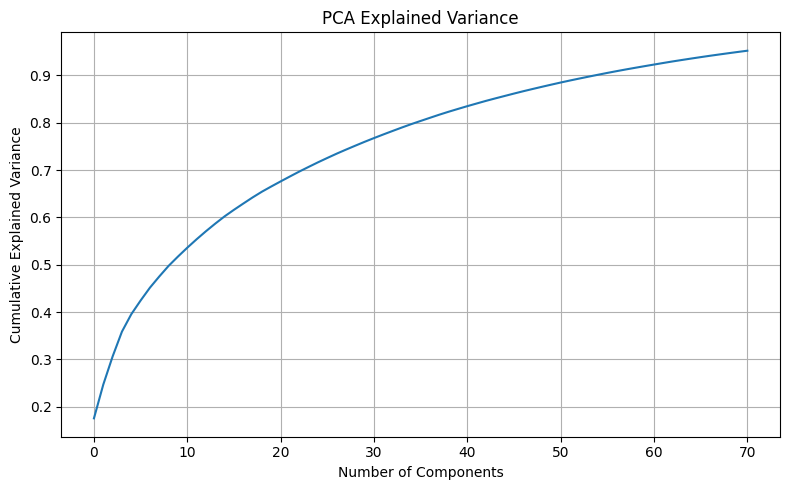

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove low-variance (nearly constant) features
vt = VarianceThreshold(threshold=0.0001)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

# Feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
selector = SelectFromModel(rf, threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🤖 LazyPredict Benchmarking

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4448, number of negative: 1355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18105
[LightGBM] [Info] Number of data points in the train set: 5803, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.766500 -> initscore=1.188653
[LightGBM] [Info] Start training from score 1.188653
Top 10 Models by Accuracy:

                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.97               0.96     0.96      0.97   
XGBClassifier               0.97               0.95     0.95      0.97   
LGBMClassifier              0.97               0.95     0.95      0.97   
ExtraTreesClassifier        0.97               0.94     0.94      0.97   
CalibratedClassifierCV      0.97      

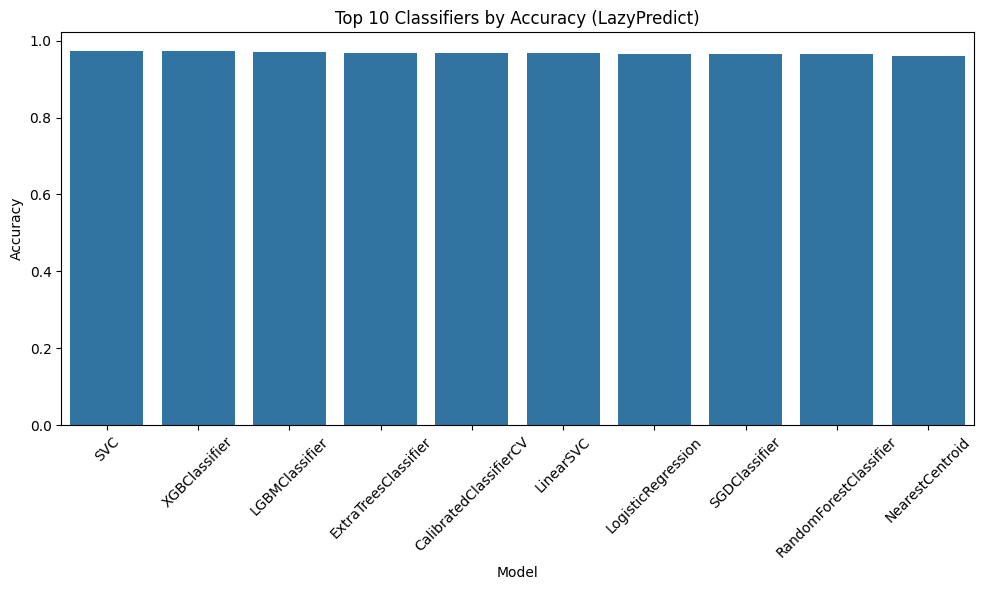

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train_pca, X_test_pca, y_train, y_test)

top_models = models.sort_values("Accuracy", ascending=False).head(10)
print("Top 10 Models by Accuracy:\n")
print(top_models)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_models.index, y=top_models['Accuracy'])
plt.xticks(rotation=45)
plt.title("Top 10 Classifiers by Accuracy (LazyPredict)")
plt.tight_layout()
plt.show()


## 🧪 Best Model Evaluation with Cross-Validation

Evaluating: SVC
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       339
           1       0.98      0.99      0.98      1112

    accuracy                           0.97      1451
   macro avg       0.97      0.96      0.96      1451
weighted avg       0.97      0.97      0.97      1451



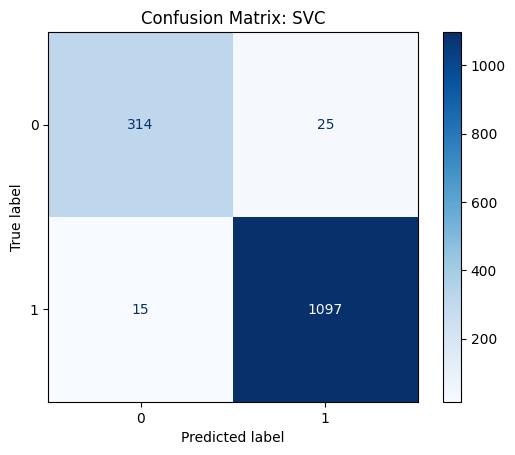

Cross-Validation Scores: [0.97243755 0.97760551 0.97243755 0.97068966 0.96896552]
Mean Accuracy: 0.9724 ± 0.0029


In [ ]:
best_model_name = top_models.index[0]
print(f"Evaluating: {best_model_name}")

model_dict = dict(all_estimators(type_filter='classifier'))
BestModelClass = model_dict[best_model_name]
best_model = BestModelClass()
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train_pca, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
